# Data and Analysis Plan: Board Game Reccomendation
## Team -1 (example)

- Piotr Sapiezynski (p.sapiezynski@northeastern.edu)
- Matt Higger (m.higger@ccs.neu.edu)

<font color='green'>
    
### Notes:
This is the example DS3000 project.  We'll switch from our official "Data and Analysis Plan" to pointing out features which are helpful as you write your own by changing the font color to green. 

**Please use the section template given here to ensure you complete the necessary sections**
</font>

<font color='green'>
(.5%) Expresses the central motivation of the project in one or two sentences. This may evolve a bit through the project.
</font>

## Project Goal:
This work will scrape lists of board games from [BoardGameGeek.com](https://boardgamegeek.com/) to reccomend a new board game to users who input a game they already enjoy. 

## Data 
<font color='green'>
(1%) Gives a summary of the data processing pipeline so a technical expert can easily follow along.
    
    
This overview section allows you to describe an overview of your data processing pipeline.  
    
Your pipeline should end by saving one or more csvs of data which will be loaded by the analysis portion of the notebook.
</font>

### Overview 
We will scrape a [list of all boardgames](https://boardgamegeek.com/browse/boardgame) ranked by popularity from BoardGameGeek.  

<img src="https://i.ibb.co/mD456p1/Screenshot-from-2021-03-14-09-25-01.png" width=800px>


From this list, for each game, we can obtain:
- title
- year published
- url to specific game page
- description (e.g. "Vanquish monsters ...")

Upon visiting an [individual game's webpage](https://boardgamegeek.com/boardgame/174430/gloomhaven) we can use the top titlebar:

<img src="https://i.ibb.co/6DdmKsg/Screenshot-from-2021-03-13-18-57-00.png" width=600px>

to observe:
- complexity rating
- playtime (mins a typical game lasts)
- min/max number of player required
- reccomended age range

Most importantly we seek to collect the category and mechanism tags associated with a particular game:
<img src="https://i.ibb.co/f1mbxVD/Screenshot-from-2021-03-13-18-56-52.png" width=150px>

Each game has multiple category tags.  Our expectation is that games with similar tags are enjoyed by similar players.  This tag data will be essential to reccomend a new game to a player who inputs another game they enjoy.  To simplify analysis, each tag will have its own column in our output DataFrame.  For example:

|       | card game | mystery | social | communication |
|-------|-----------|---------|--------|---------------|
| game0 | True      | True    | False  | False         |
| game1 | False     | True    | True   | True          |

Indicates that 
- game0 has tags 'card game' and 'mystery'
- game1 has tags ' mystery', 'social' and 'communication'

### Pipeline Overview

We will accomplish this task with three functions:
- `get_url()`
    - returns html string of a given url
- `clean_top_games()`
    - builds dataframe of [a single page of top games](https://boardgamegeek.com/browse/boardgame/page/2) from html string 
- `clean_game_meta()`
    - collects game meta data (tags, complexity, playtime, min/max players, age range ...) from an [individual game's webpage](https://boardgamegeek.com/boardgame/174430/gloomhaven)
    
As well as two short scripts:
- **Scrape list of games:** use `get_url()` and `clean_top_games()` in a loop to collect n pages of top games (100 * n games), populating a DataFrame `df_game`
- **Get meta data per game:** loop through each row of `df_game`, query and process the individual game's webpage via `get_url()` and `clean_game_meta()` using the previously collected url and append the remaining features to `df_game`

### Pipeline
<font color='green'>
    
(4%) Obtains, cleans, and merges all data sources involved in the project.
    
Documentation counts!
    
The majority of this section is code, but do make sure that one can do a quick sanity check that your pipeline worked by printing a few examples (e.g. call `DataFrame.head()` a few times).
</font>

#### Scrape list of games

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import json
import time
from tqdm import tqdm
import seaborn as sns

In [2]:
def get_url(url):
    """ gets the html of a given url
    
    Args:
        url (str): target url
        
    Returns:
        str_html (str): html of given url
    """
    return requests.get(url).text

In [3]:
def clean_top_games(str_html):
    """ gets DataFrame of games from page of "All Boardgames" list
    
    example page from "All Boardgames":
    https://boardgamegeek.com/browse/boardgame/page/2
    
    Args:
        str_html (str): string corresponding to html of page
        
    Returns:
        df_game (pd.DataFrame): dataframe where each row
            is one board game
    """    
    # build soup
    soup = BeautifulSoup(str_html)

    # get game data per row (discard first row as its the title)
    df_game = pd.DataFrame()
    for row_game in soup.find_all('tr')[1:]:
        game_dict = dict()
        
        # each td tag corresponds to a column.  we unpack by column
        rank, image, title_year, rate_geek, rate_avg, num_vote, shop = row_game.find_all('td')
        
        # get game id and url from link in image
        game_url = 'https://boardgamegeek.com' + image.a.attrs['href']
        game_dict['url'] = game_url
        game_dict['game_id'] = game_url.split('/')[-2]
    
        # get title        
        game_dict['title'] = title_year.a.text.strip()
        
        # get year
        str_year = title_year.span.text
        str_year = str_year.replace('(', '').replace(')', '')
        game_dict['year'] = int(str_year)
        
        # try to get description (set empty if fail)
        try:
            game_dict['description'] = title_year.p.text.strip()
        except:
            game_dict['description'] = ''
        
        # add game to total dataframe
        df_game = df_game.append(game_dict, ignore_index=True)
        
    # set game_id as index
    df_game.set_index('game_id', inplace=True)
    
    return df_game

In [4]:
num_page = 10

# scrape the top 100 * num_page games and save to csv
df_game_list = []
for page_idx in tqdm(range(1, num_page + 1), desc='scraping page'):
    
    # get url of a given page_idx
    url = f'https://boardgamegeek.com/browse/boardgame/page/{page_idx}?sort=rank'
    str_html = get_url(url)
    
    # clean game data and store it in list
    df_game = clean_top_games(str_html)
    df_game_list.append(df_game)
    
    # pause so we don't overwhelm the website (may not respond if we query too quickly)
    time.sleep(1)
    
# glue together all rows of all dataframes
df_game = pd.concat(df_game_list)

# discard games with same titles as others
df_game.drop_duplicates(subset='title', inplace=True)

# save / print
df_game.to_csv('game.csv')
df_game.head()

scraping page: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


,description,title,url,year
game_id,,,,
174430,Vanquish monsters with strategic cardplay. Ful...,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,2017.0
161936,Mutating diseases are spreading around the wor...,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pan...,2015.0
224517,"Build networks, grow industries, and navigate ...",Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/bra...,2018.0
167791,Compete with rival CEOs to make Mars habitable...,Terraforming Mars,https://boardgamegeek.com/boardgame/167791/ter...,2016.0
233078,"Build an intergalactic empire through trade, r...",Twilight Imperium: Fourth Edition,https://boardgamegeek.com/boardgame/233078/twi...,2017.0


#### Get metadata per game:

In [5]:
def clean_game_meta(str_html):
    """ given HTML source of a game page, extract game stats
    
    Args:
        str_html (str): html of the page
        game_id (int): game identifier
        
    Returns:
        game_dict (dict): dictionary representing metadata and stats about a given game
    """
    soup = BeautifulSoup(str_html)
    
    # all the content is hidden as json in JavaScript rather than in html 
    # so we need to hack a bit to get to it
    script = soup.find_all('script')[1]
    
    # the actual content of the page is stored in a JavaScript variable called
    # GEEK.geekitemPreload, so let's get its value
    for var in script.contents[0].split('\n\t'):
        if var.startswith('GEEK.geekitemPreload'):
            data = json.loads(var.split('GEEK.geekitemPreload = ')[1][:-1])['item']
    
    game_dict = dict()
    game_dict['player_age'] = data['polls']['playerage']

    # not all games have the info on best_players_min
    try:
        game_dict['best_players_min'] = game_dict['polls']['userplayers']['best'][0]['min']
    except:
        game_dict['best_players_min'] = None
    
    # not all games have the info on best_players_max
    try:
        game_dict['best_players_max'] = data['polls']['userplayers']['best'][0]['max']
    except:
        game_dict['best_players_max'] = None
        
    game_dict['recomm_players_min'] = data['polls']['userplayers']['recommended'][0]['min']
    game_dict['recomm_players_max'] = data['polls']['userplayers']['recommended'][0]['max']
    game_dict['playtime_min'] = data['minplaytime']
    game_dict['playtime_max'] = data['maxplaytime']
    game_dict['awards'] = len(data['links']['boardgamehonor'])
    game_dict['difficulty'] = data['polls']['boardgameweight']['averageweight']
    game_dict['category'] = [cat['name'] for cat in data['links']['boardgamecategory']]
    game_dict['mechanic'] = [cat['name'] for cat in data['links']['boardgamemechanic']]
    
    return game_dict

In [6]:
for game_id, game_row in tqdm(df_game.iterrows(), desc='scraping per game', total=df_game.shape[0]):
    # get game meta data from game specific page
    html_str = get_url(game_row['url'])
    try:
        game_dict = clean_game_meta(html_str)
    except:
        # failure to get game metadata ("Ascension: Storm of Souls")
        # drop this game from the database
        game_title = game_row['title']
        print(f'error getting meta data: {game_title} (removing from df_game)')
        df_game.drop(game_id, inplace=True)
        continue
    
    # add this game data to our dataframe    
    for col, feat in game_dict.items():
        if col in ('category', 'mechanic'):
            # each game may have multiple 'category' or 'mechanic' groups it belongs to
            # we build a unique column for each unique tag
            
            # get prefix (so we can distinguish category/mechanic tags later)
            if col == 'category':
                prefix = 'cat: '
            else:
                prefix = 'mech: '
                
            # save each group as its own column
            for tag in feat:
                tag =  prefix + tag
                df_game.loc[game_id, tag] = True
        else:
            # column has a single value, update df_game
            df_game.loc[game_id, col] = feat
        
    time.sleep(1)

scraping per game:  72%|███████▏  | 710/993 [03:05<01:00,  4.67it/s]

error getting meta data: Ascension: Storm of Souls (removing from df_game)


scraping per game: 100%|██████████| 993/993 [04:16<00:00,  3.88it/s]


In [7]:
for col in df_game.columns:
    if ('cat: ' in col) or ('mech: ' in col):
        df_game.fillna(value={col: False}, inplace=True)

In [8]:
df_game.to_csv('game.csv')

In [9]:
df_game.head()

,description,title,url,year,player_age,best_players_min,best_players_max,recomm_players_min,recomm_players_max,playtime_min,...,cat: Trivia,mech: Map Deformation,mech: Measurement Movement,mech: Auction: Dutch Priority,mech: Single Loser Game,mech: Stacking and Balancing,mech: Action Timer,mech: Physical Removal,mech: Induction,mech: Ratio / Combat Results Table
game_id,,,,,,,,,,,,,,,,,,,,,
174430,Vanquish monsters with strategic cardplay. Ful...,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,2017.0,14+,NaN,3.0,1.0,4.0,60,...,False,False,False,False,False,False,False,False,False,False
161936,Mutating diseases are spreading around the wor...,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pan...,2015.0,12+,NaN,4.0,2.0,4.0,60,...,False,False,False,False,False,False,False,False,False,False
224517,"Build networks, grow industries, and navigate ...",Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/bra...,2018.0,14+,NaN,4.0,2.0,4.0,60,...,False,False,False,False,False,False,False,False,False,False
167791,Compete with rival CEOs to make Mars habitable...,Terraforming Mars,https://boardgamegeek.com/boardgame/167791/ter...,2016.0,12+,NaN,3.0,1.0,4.0,120,...,False,False,False,False,False,False,False,False,False,False
233078,"Build an intergalactic empire through trade, r...",Twilight Imperium: Fourth Edition,https://boardgamegeek.com/boardgame/233078/twi...,2017.0,14+,NaN,6.0,3.0,6.0,240,...,False,False,False,False,False,False,False,False,False,False


### Visualizations (sanity check / data exploration)
<font color='green'>
    
(2.5%) Builds two visualizations (graphs) from the data which characterize the distribution of the data itself in some interesting way. Your visualizations will be graded based on how much information they can effectively communicate with readers. Please make sure your visualizations are sufficiently distinct from each other.

**Wherever a non-technical reader may misunderstand, write a few sentences which specify how to interpret the graph**  It is expected that a non-technical reader can fully digest your graphs based on the images themselves as well as your explanatory text (they won't read your code).
    
Notice that the pipeline above takes 20 mins or so to complete.  We have manually re-labelled `game.csv` to `game_final.csv` so that:
- we don't overwrite our precious dataset
- we can load it below and continue on with our graphs

You won't lost any credit for not using a `_final.csv` structure in your code but I'd encourage you to do so to avoid losing your data / time :)
</font>



#### Correlations between category tags

In [10]:
df_game = pd.read_csv('game_final.csv')

In [11]:
def plot_corr_matrix(df_game, prefix, limit=10):
    # find all columns with a given prefix
    column_list = [col for col in df_game.columns if prefix in col]

    # get dataframe corresponding to column_list
    df = df_game.loc[:, column_list]
    
    # get series of tags, sorted in decreasing popularity
    series_tag = df.sum(axis=0).sort_values(ascending=False)
    
    # get limit most popular tags from df
    df = df_game.loc[:, series_tag.index[:limit]]

    # rename all columns
    df.columns = [col[len(prefix):] for col in df.columns]

    # plot
    sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='coolwarm')
    plt.gcf().set_size_inches(10, 10)

Text(0.5, 0.98, 'Correlation of category tags')

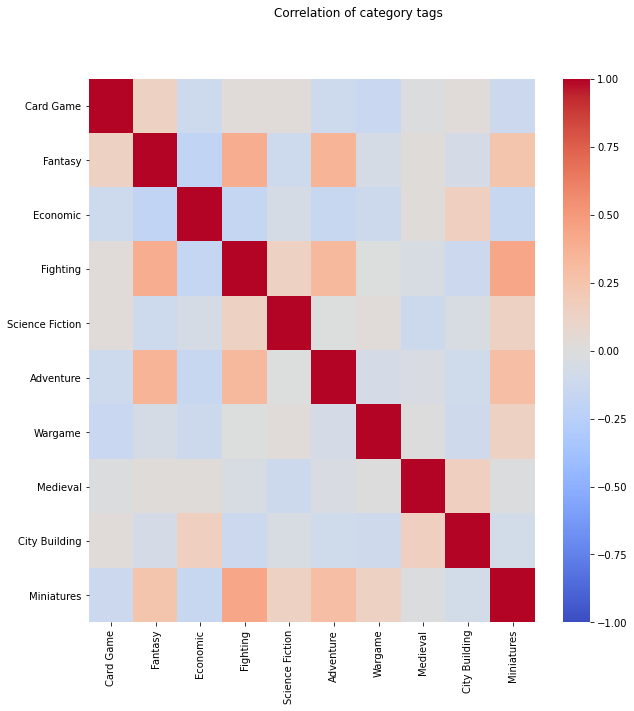

In [12]:
plot_corr_matrix(df_game, prefix='cat: ')
plt.suptitle('Correlation of category tags')

Higher values, shown in red, indicate that the categories tend to occur in the same game.  For example, the final row (or column) describes games with miniatures.  Minatures (i.e. little plastic figurines) are often in games with:
- Fantasy
- Fighting
- Science fiction
- Adventure
- Wargame

However, games with miniatures often do not also belong to the following categories:
- Card Game
- Economic
- City Building

#### Duration of gameplay

Text(0, 0.5, 'count')

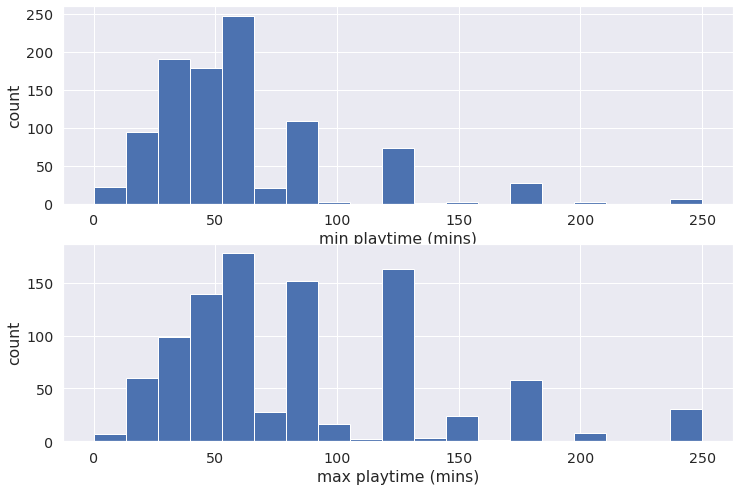

In [13]:
import numpy as np

sns.set(font_scale=1.3)

fig, axs = plt.subplots(2, 1)
fig.set_size_inches(12, 8)

# plot histogram min playtime
plt.sca(axs[0])
bins = np.linspace(0, 250, 20)
plt.hist(df_game['playtime_min'], bins=bins)
plt.xlabel('min playtime (mins)')
plt.ylabel('count')

# plot histogram max playtime
plt.sca(axs[1])
plt.hist(df_game['playtime_max'], bins=bins)
plt.xlabel('max playtime (mins)')
plt.ylabel('count')

## Analysis Plan
<font color='green'>
    
(2%) Discuss what ML tools will be used and the relevant assumptions required to apply each. Either:

discuss why one algorithm may be chosen over the others

describe what subset of a whole suite of similar algorithms you’ll apply (its ok to say, ‘we’re going to try all of these because we don’t have reason to think one should be better than another’)

For example:

- Project goal: Predicting the movement of stock prices based on how similar companies are doing via regression.
    - This is observable: there are plenty of information you could collect about stock prices (though it will need some careful though about what a "similar" company is)
    - This is sound and simple: seems intuitive that there'd be a relationship to be found between the company's stock prices
    
- Project goal: Recommend a movie based on the events of a person's dream last night.
    - This is not observable: how will you get enough data on what people dreamed about?
    - This is not sound or simple: what kind of movies should we suggest for people with nightmares of falling?  Doesn't seem to be a clear relationship between dreams / movies a person would enjoy ....
    
    
To date, we've covered data collection and processing extensively and are only starting ML this week (Mar 22).  The grading will account for this:
- be specific / clear about which data will be used
    - give plenty of examples to illustrate things
- be as specific / clear as you can about the ML analysis
</font>

Our expectation is that games with similar categories would be enjoyed by similar board gamers. 

In each of the approaches below, a board game is characterized by a boolean vector $x$ which represents all the category and mechanics tags a board game could contain.  For example, the fifth game can be represented by:

In [14]:
feat_col = [col for col in df_game.columns if 'mech: ' in col or 'cat: ' in col]
df_feat = df_game.loc[:, feat_col]
df_feat.iloc[4, :]

cat: Adventure                        False
cat: Exploration                       True
cat: Fantasy                          False
cat: Fighting                         False
cat: Miniatures                       False
                                      ...  
mech: Stacking and Balancing          False
mech: Action Timer                    False
mech: Physical Removal                False
mech: Induction                       False
mech: Ratio / Combat Results Table    False
Name: 4, Length: 250, dtype: bool

We will ask users to rate, on a 1-7 point scale, 10 or more board games.  For example, some user might rate:

In [15]:
example_user_rate = \
{'Gloomhaven': 7,
'Pandemic Legacy: Season 1': 1,
'Brass: Birmingham': 3,
'Terraforming Mars': 2,
'Twilight Imperium: Fourth Edition': 4,
'Gloomhaven: Jaws of the Lion': 7,
'Through the Ages: A New Story of Civilization': 5,
'Gaia Project': 2,
'Star Wars: Rebellion': 3,
'Twilight Struggle': 4}

For every user, we will use regression to create a function which estimates these ratings from the $x$ vector above.  This function can then be applied to all the $x$ values above, including the games for which the user has not indicated a rating.  We will "reccomend" those games with the highest estimated rating (i.e. the output of the regression function) which the user has not explicitly rated.